In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import sportran as st
import numpy as np
import matplotlib.pyplot as plt
import opt_einsum
import pandas as pd

In [214]:
from scipy.interpolate import CubicSpline, interp1d
def model_scalar(x, y):
    return CubicSpline(np.concatenate([-x[::-1], x[1:]]), np.concatenate([y[::-1], y[1:]]))

n = 2
def model_wishart_(x, y):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    y00, y01, y11 = y.reshape(3,l)
    yy = np.array([[y00, y01], [np.zeros_like(y01), y11]]).T
    # yy = np.einsum('tab,tbc->tac', np.transpose(yy, axes=(0,2,1)), yy)
    yy = np.concatenate([yy[::-1], yy[1:]])
    # return interp1d(xx, yy)) 
    return CubicSpline(xx, yy) #, bc_type = 'clamped')

import numpy as np
from scipy.interpolate import CubicSpline

def model_wishart(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    upper_triangle_indices = np.triu_indices(N)
    y_elements = y.reshape(len(upper_triangle_indices[0]), l)
    
    yy = np.zeros((l, N, N))
    for k, (i, j) in enumerate(zip(*upper_triangle_indices)):
        yy[:, j, i] = y_elements[k]
    
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

# # Example usage
# N = 20  # For a 3x3 matrix
# x = np.array([1, 2, 3])
# y = np.random.rand(int(N*(N+1)/2), x.size)  # Generate random upper triangular elements
# spline = model_wishart(x, y)
# # spline2 = model_wishart_(x, y)
# print(spline(x).shape) #-spline2(x))


In [52]:
dc=np.load('data/bayesian/CsF/dc_minimal.npy', allow_pickle = True).item()

In [274]:
flux = st.HeatCurrent([
    dc['qflux'],
    dc['ele_flux']
    ],
                       DT_FS=1,
                       TEMPERATURE=dc['Temeprature'],
                       VOLUME=dc['Volume'],
                       UNITS='metal')

Using multicomponent code.


In [275]:
flux_resample=flux.resample(fstar_THz=20)

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      20.00000 THz
 Sampling time         TSKIP =            25 steps
                             =        25.000 fs
 Original  n. of frequencies =        100001
 Resampled n. of frequencies =          4001
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00018
 % of original PSD Power f<f* (pre-filter&sample)  = 99.707 %
 fPSD not calculated before resampling
 -----------------------------------------------------



In [276]:
flux_resample.maxlike_estimate(lambda x, y: model_wishart(x, y, 2), 20)

MaxLikeFilter
Maximum-likelihood estimate with 20 parameters
Spline nodes are equispaced from 0 to the Nyquist frequency.


In [263]:
data_wishart.shape

(4001, 3, 3)

/var/folders/1h/l4hl5gdn4j55pcw3tbrrx2c80000gn/T/ipykernel_93788/2933677822.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


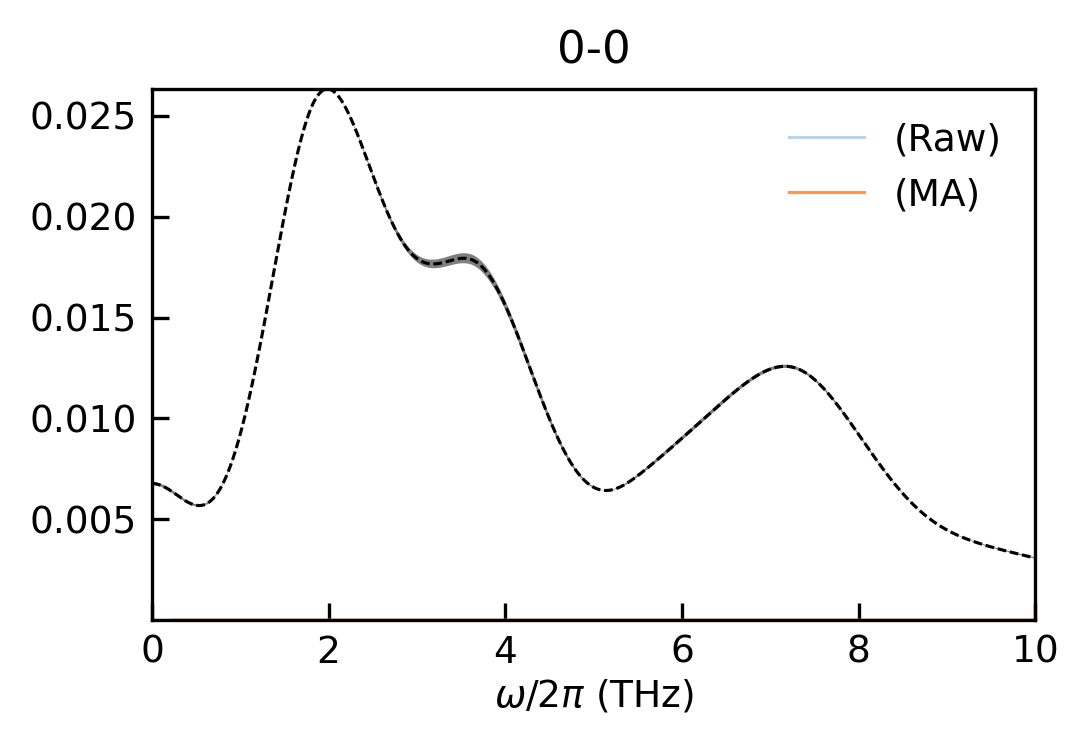

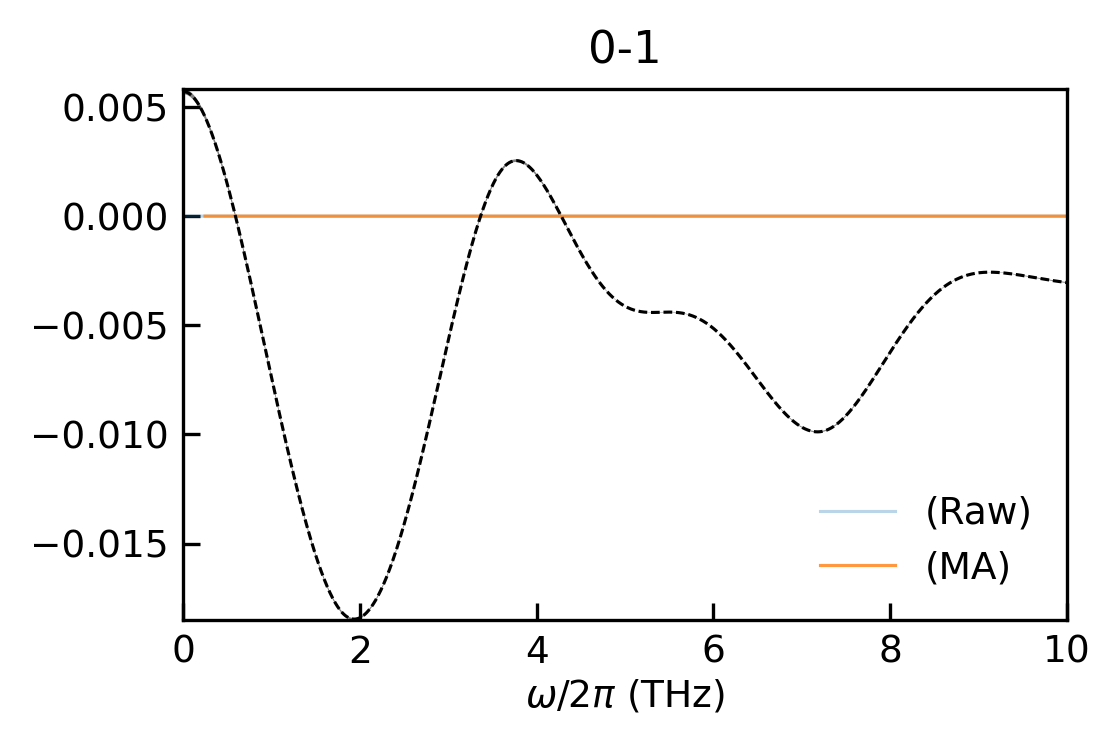

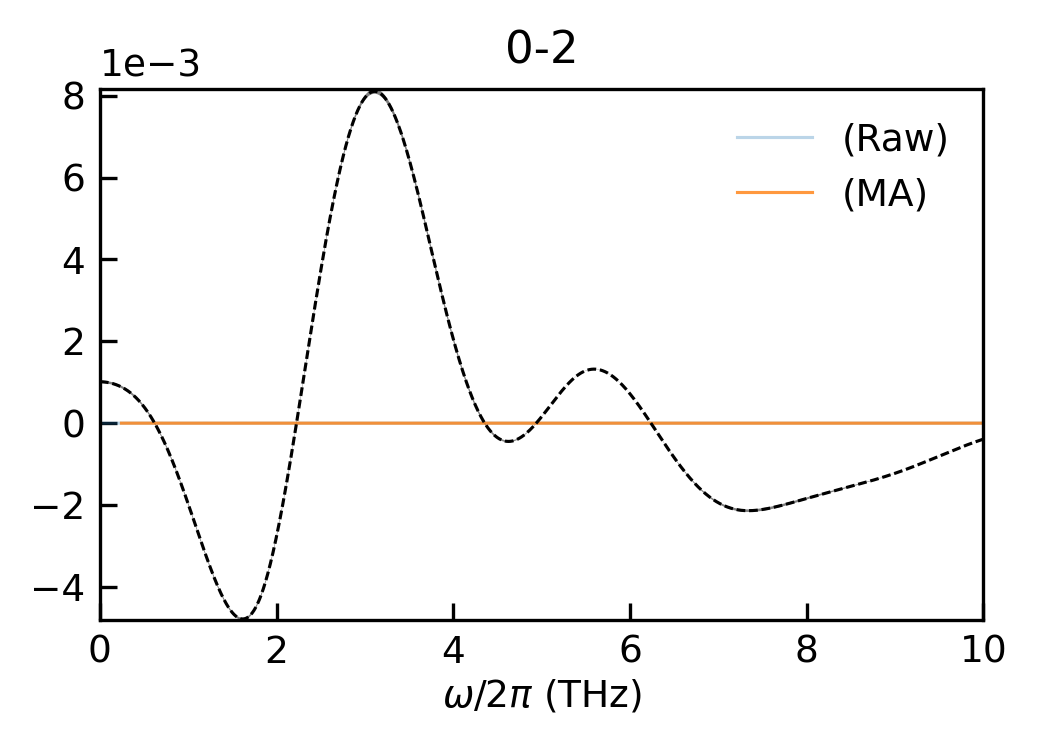

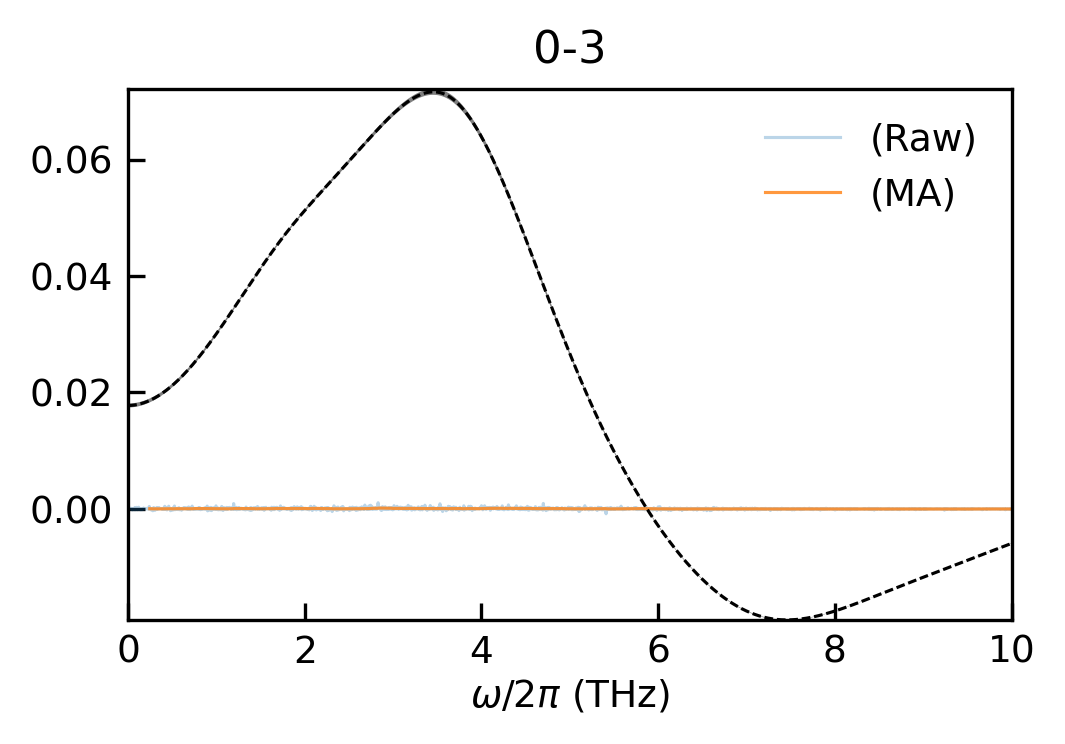

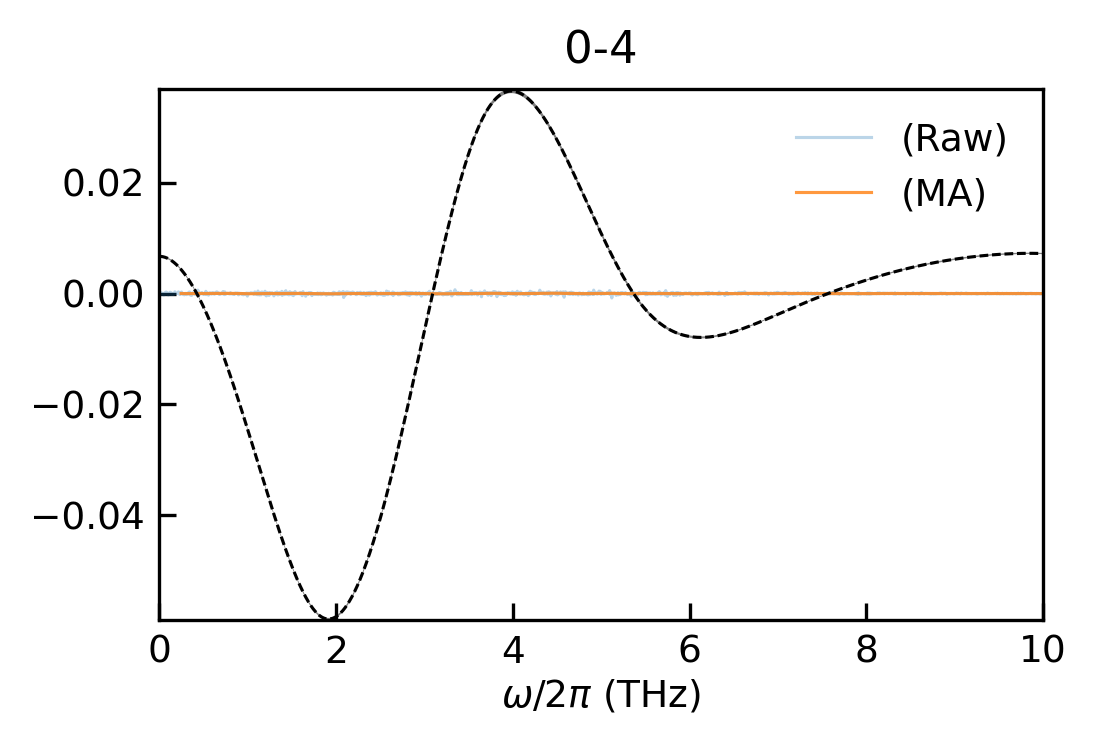

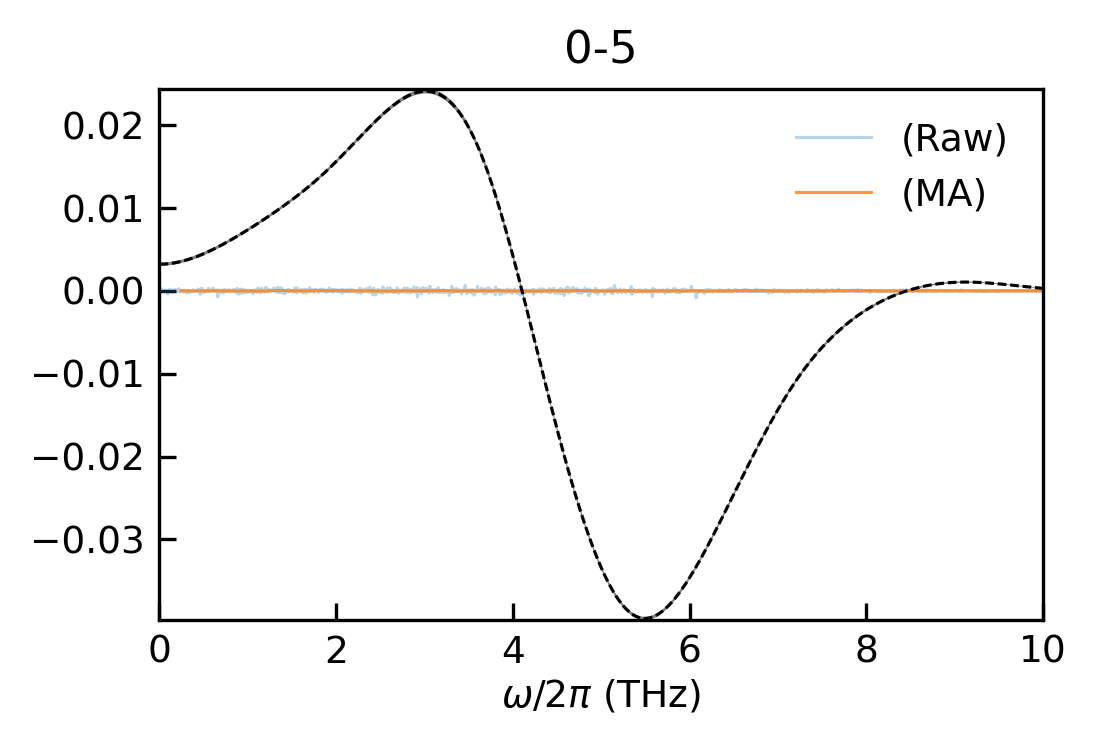

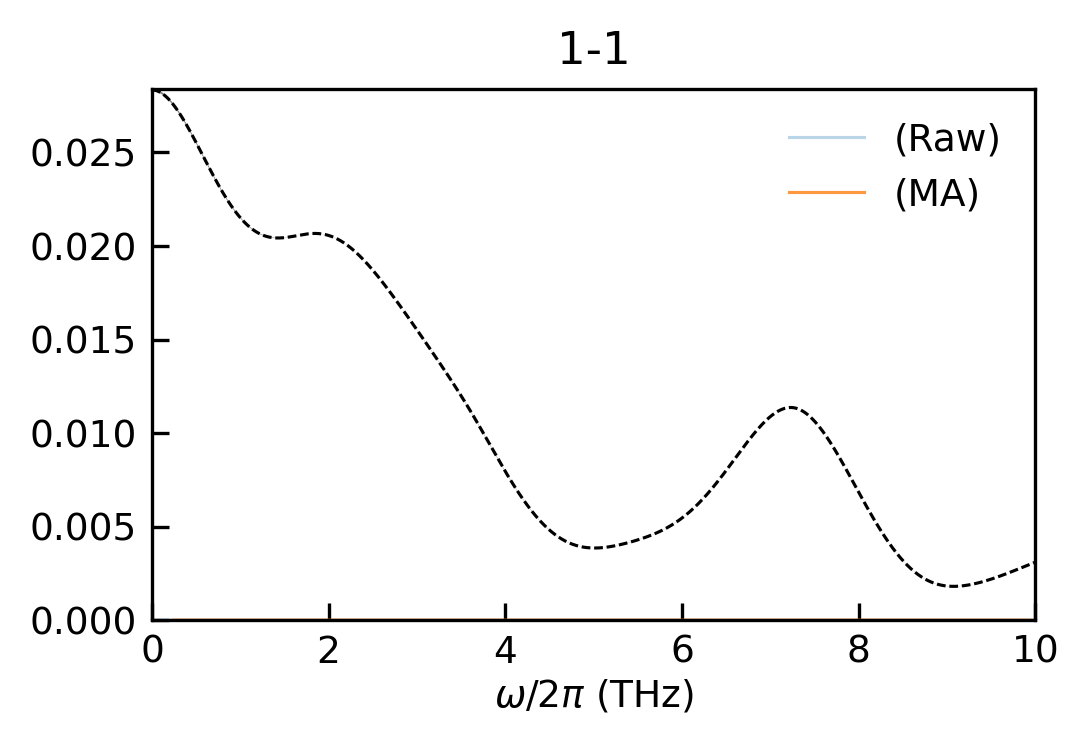

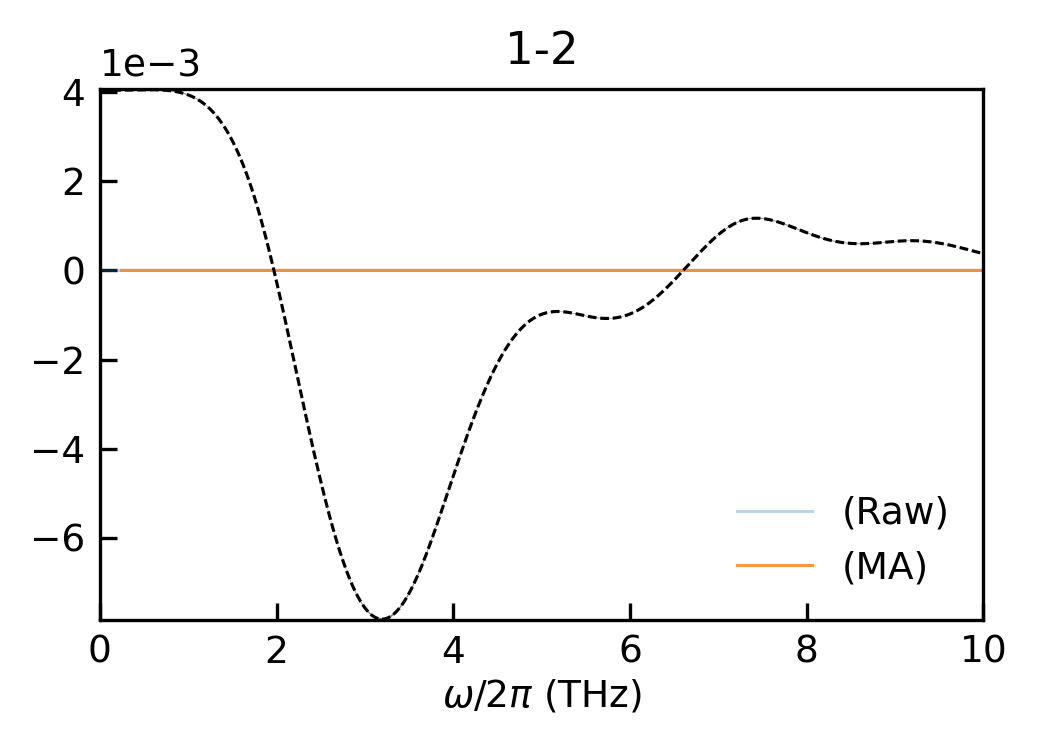

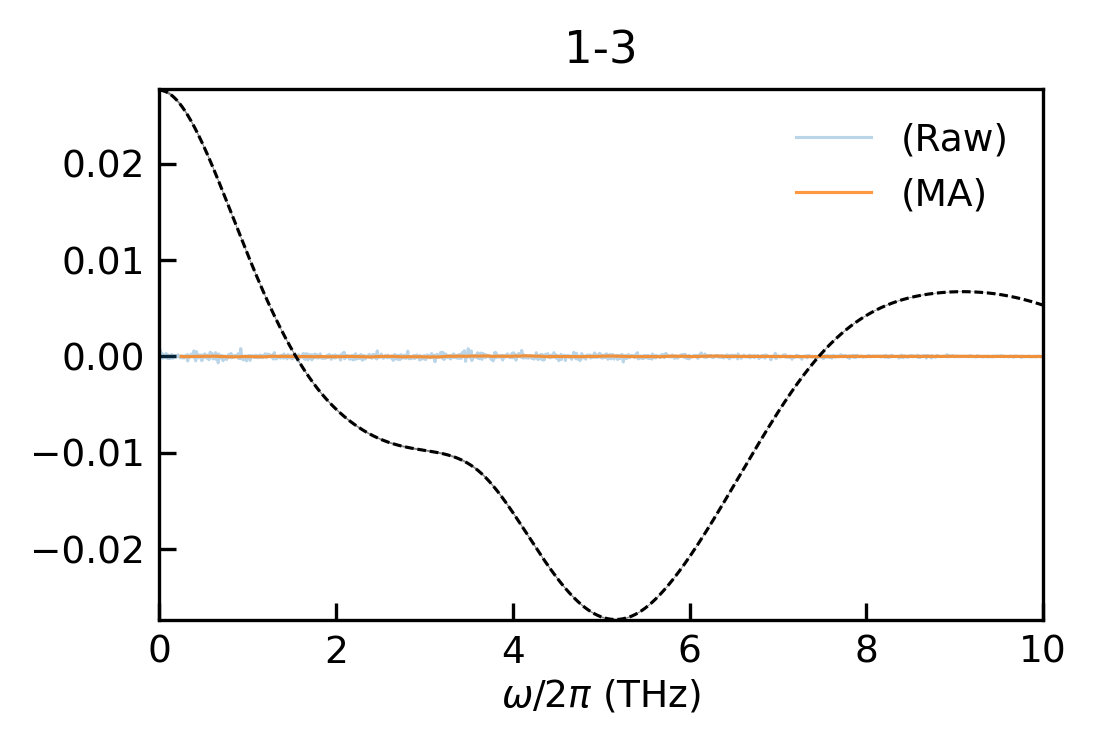

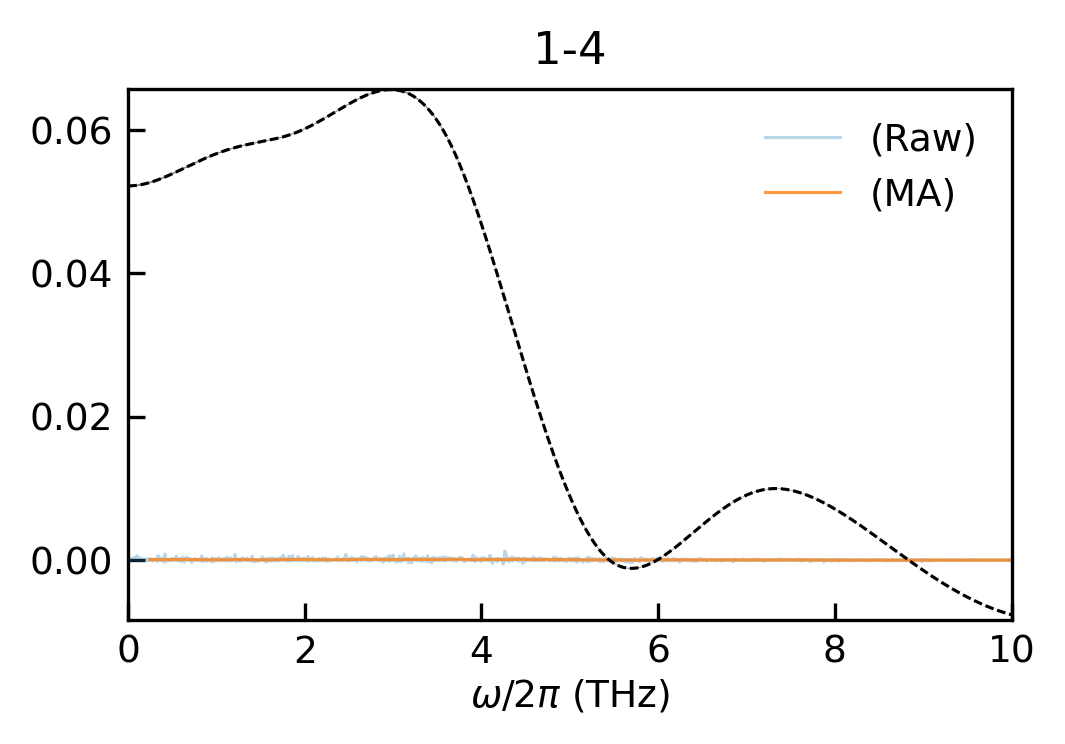

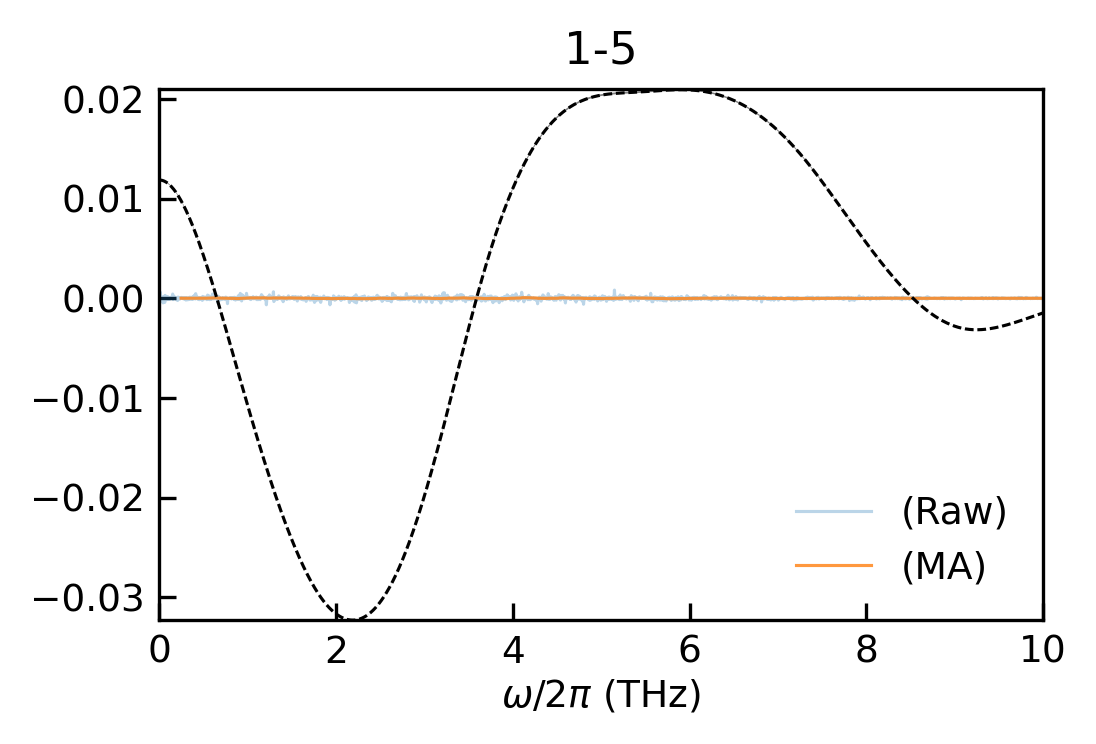

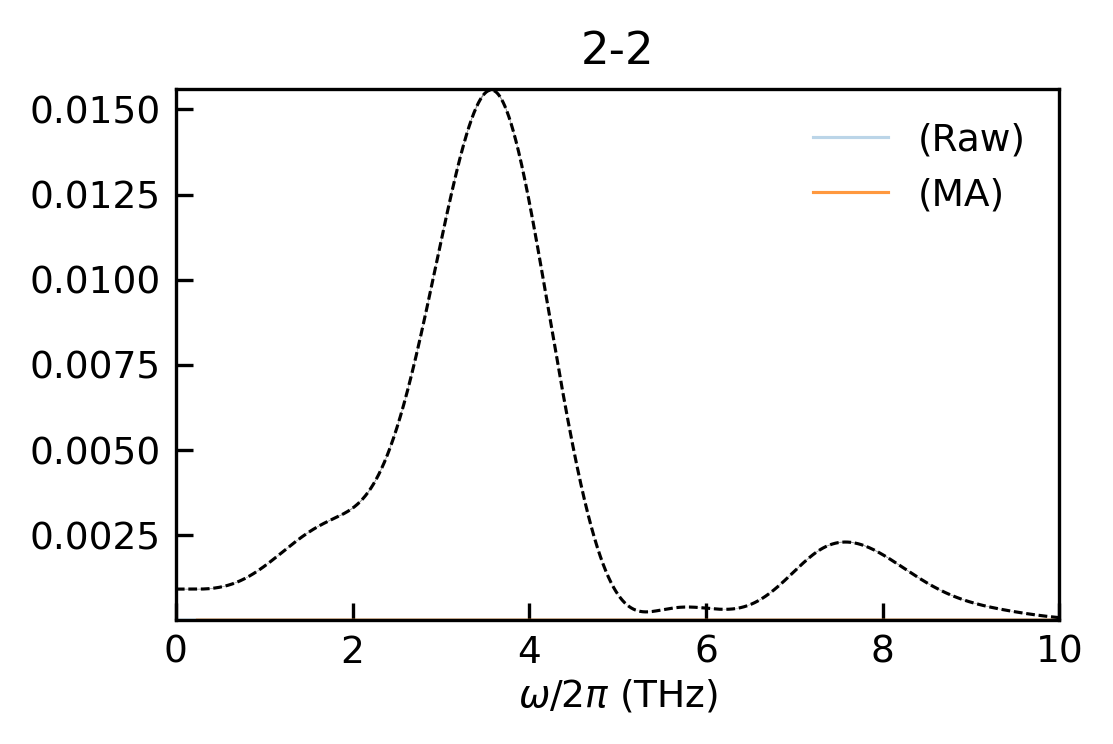

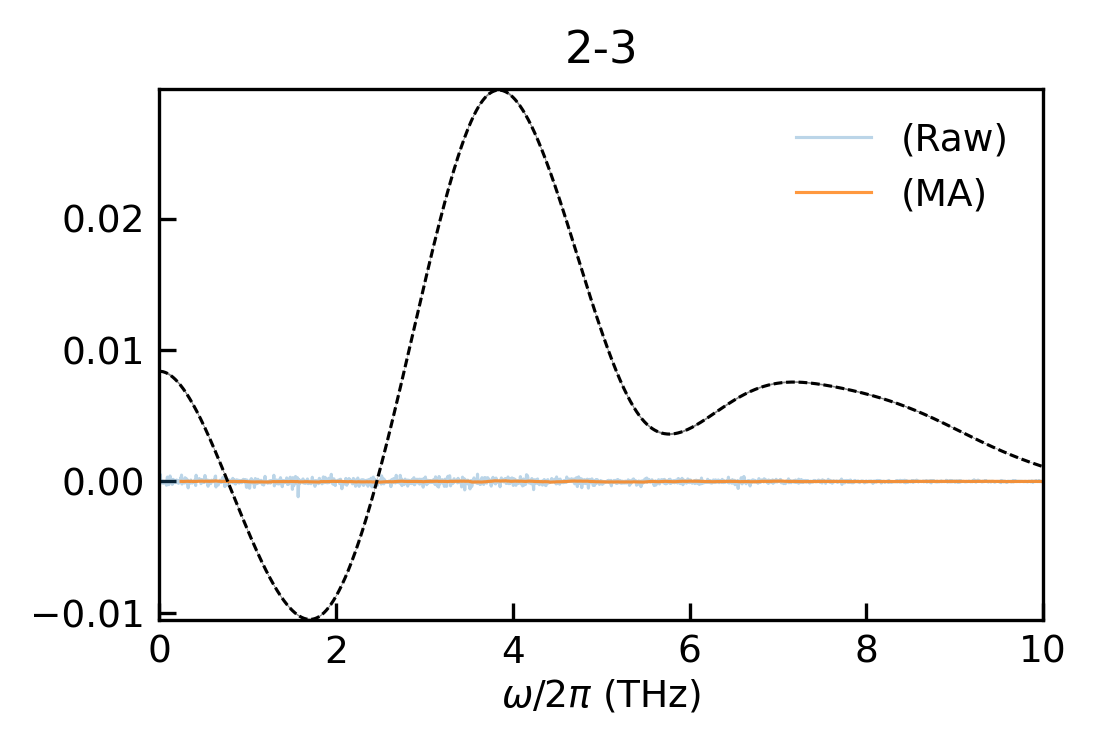

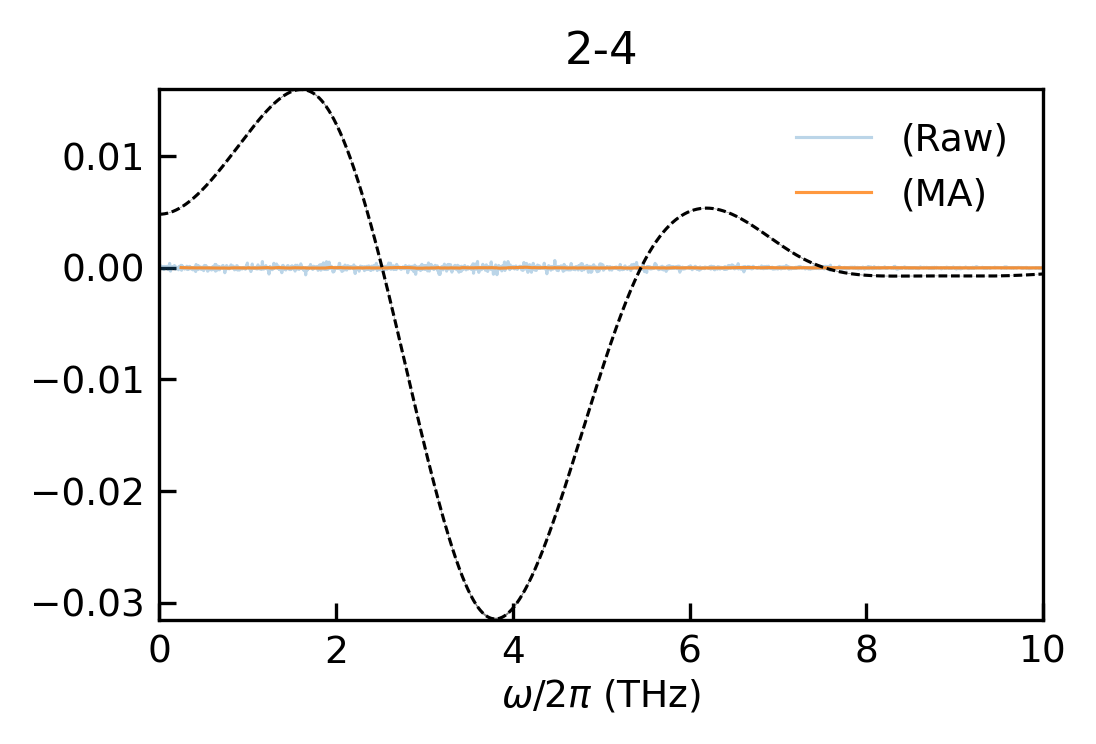

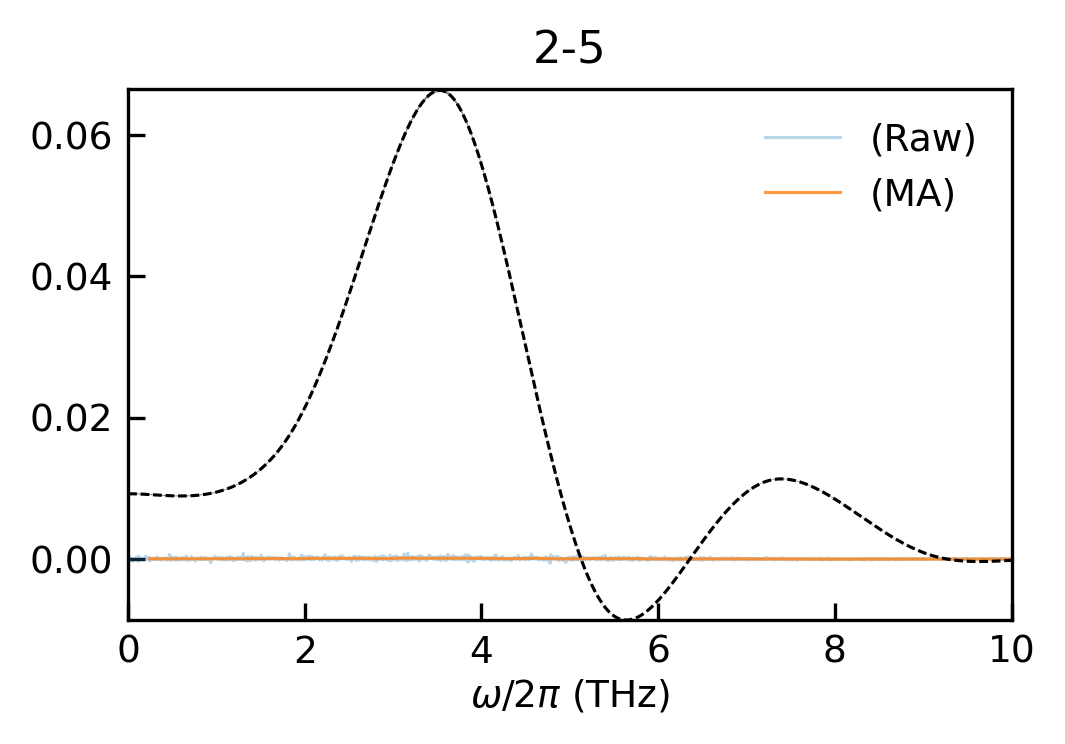

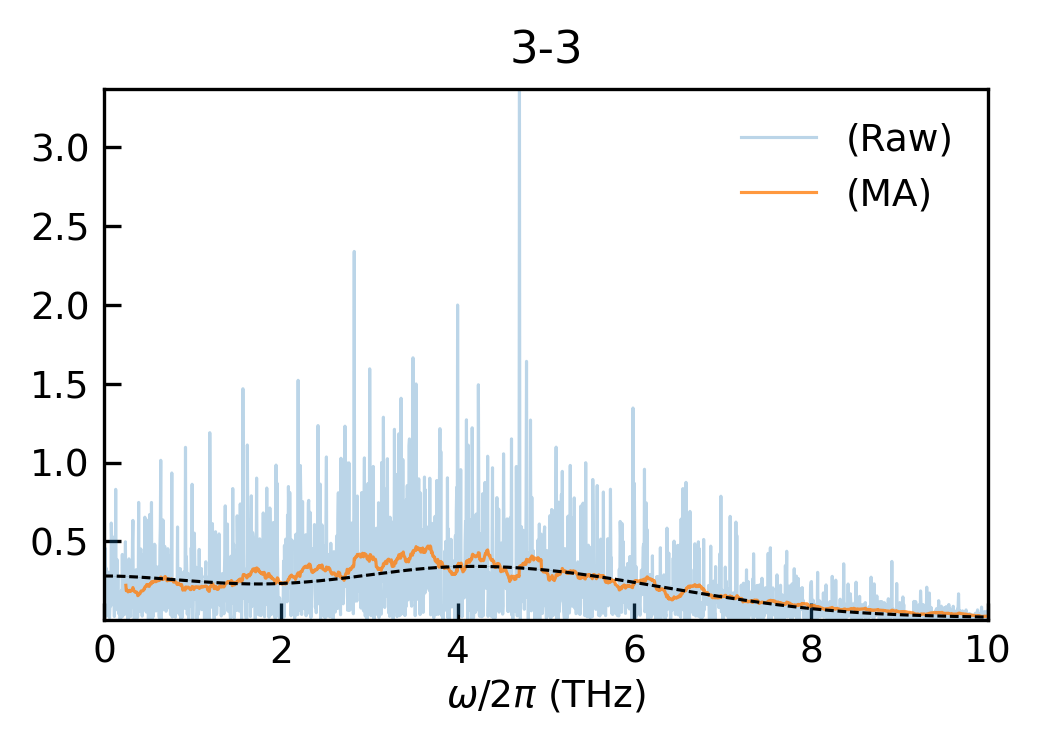

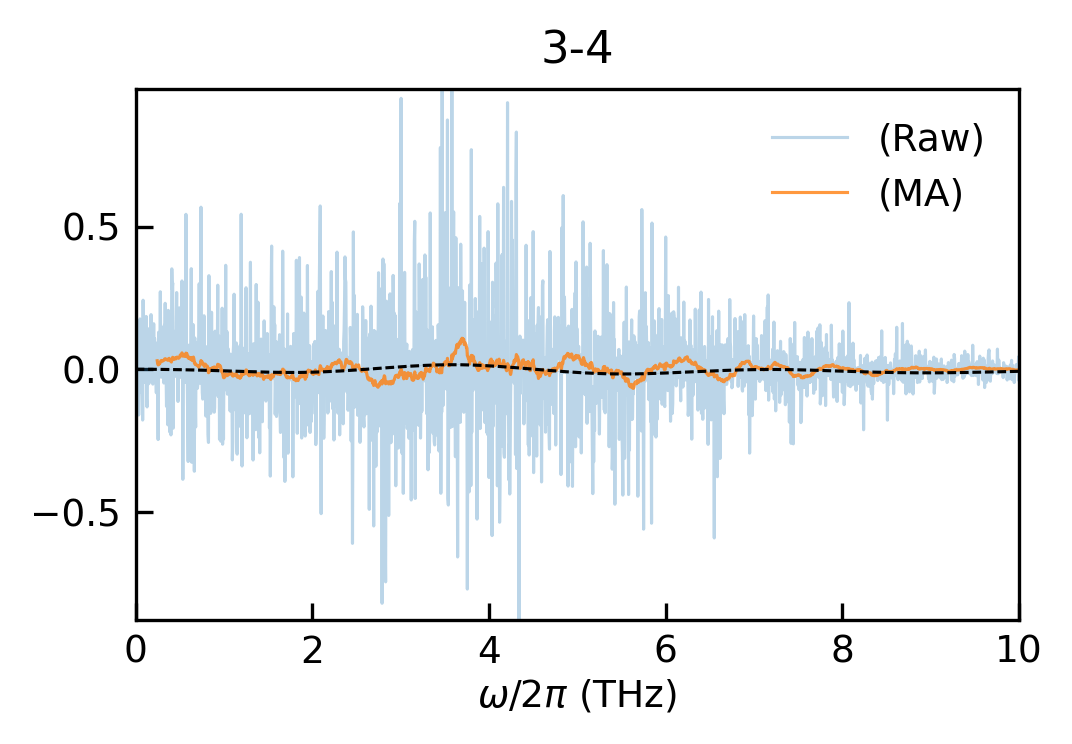

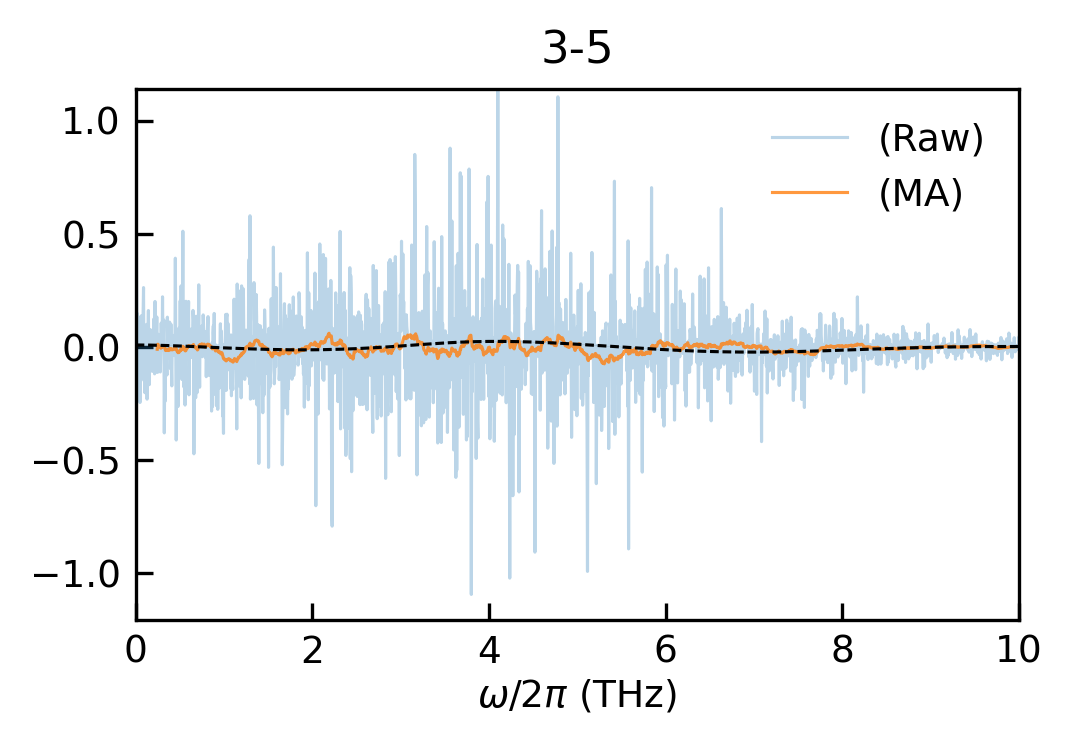

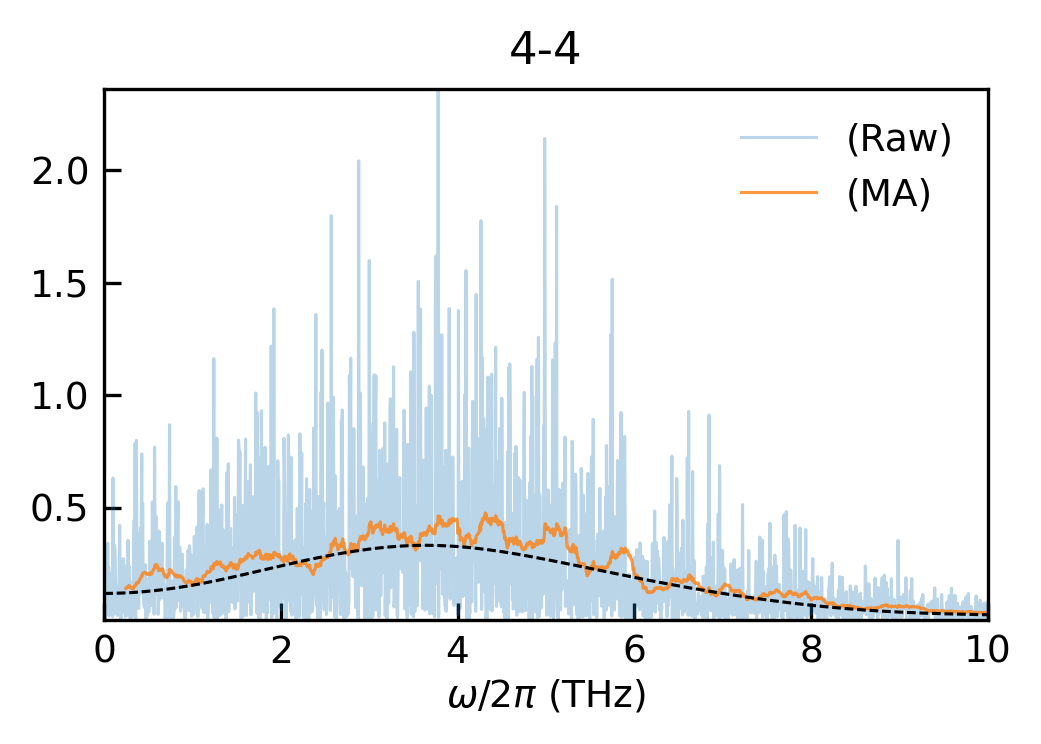

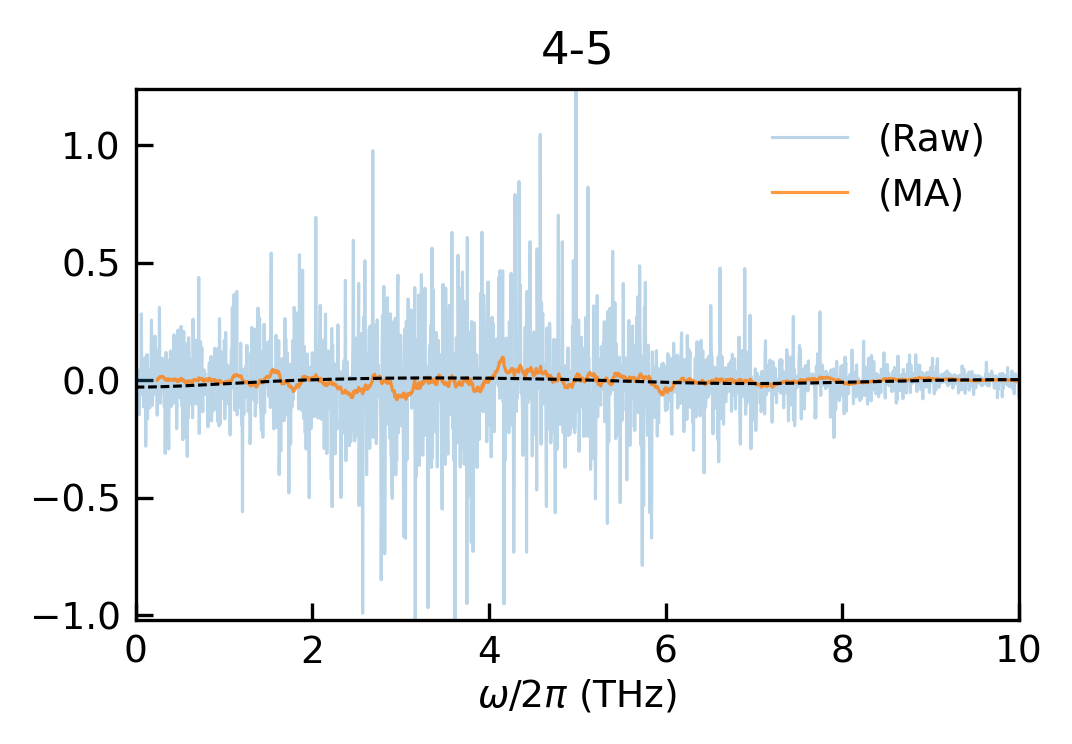

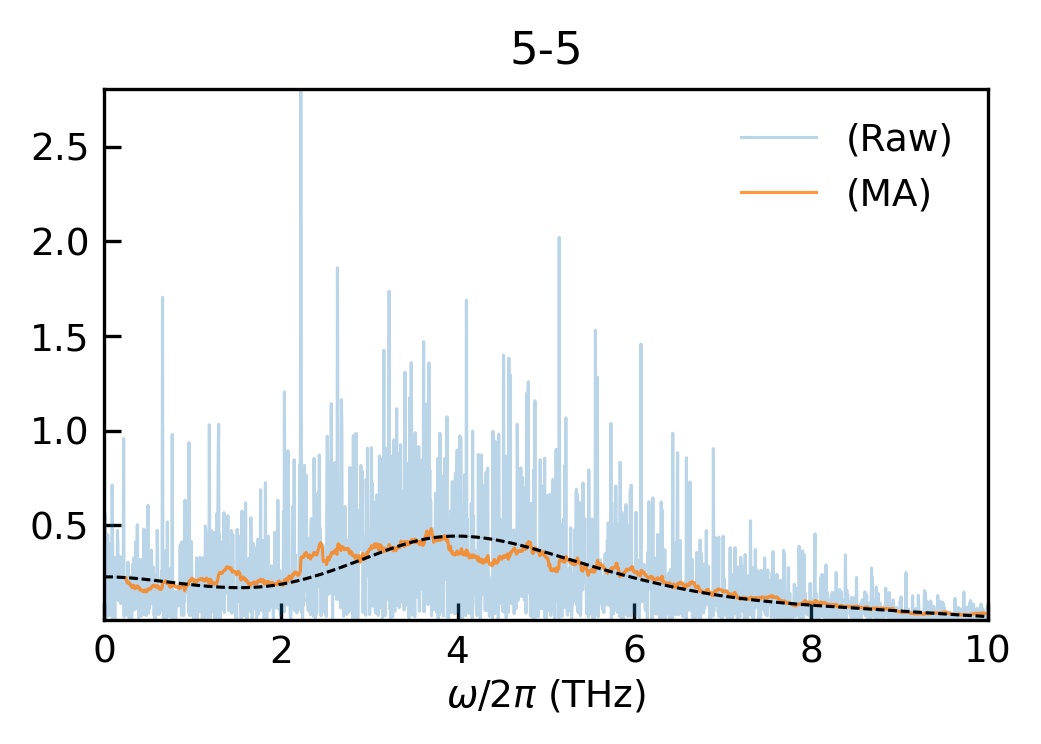

In [272]:
omega = flux_resample.maxlike.omega

data_wishart = flux_resample.maxlike.data

estimate = flux_resample.NLL_spline(omega)
estimate_p = flux_resample.NLL_spline_upper(omega)
estimate_m = flux_resample.NLL_spline_lower(omega)

# comp = {(0,0): 'qq', (0,1): 'cq', (1,1): 'cc'}

ip = 0
addaxes = []
# colors = ['tab:blue', 'tab:red', 'tab:green']
icol = 0

N = data_wishart.shape[-1]
for i in range(N):
    for j in range(i, N):
        fig, ax = plt.subplots()

        pl, = ax.plot(flux_resample.freqs_THz, 
                      data_wishart[:, i, j]*flux_resample.KAPPA_SCALE/2, 
                      alpha = 0.3, 
                      label = f'(Raw)', 
                #       color = colors[icol]
                )
        
        ax.plot(flux_resample.freqs_THz, 
                pd.Series(data_wishart[:, i, j]).rolling(window=50).mean()*flux_resample.KAPPA_SCALE/2, 
                alpha = 0.8, 
                label = f'(MA)', 
                # color = colors[icol]
                )
        
        icol += 1
        
        x, y = flux_resample.freqs_THz, estimate[:, i, j]*flux_resample.KAPPA_SCALE/2
        ym, yp = estimate_m[:, i, j]*flux_resample.KAPPA_SCALE/2, estimate_p[:, i, j]*flux_resample.KAPPA_SCALE/2
        
        ax.plot(x, 
                y, 
                color = 'k', 
                ls = '--')
         
        ax.fill_between(x, 
                        ym, 
                        yp, 
                        color = 'k', 
                        alpha = 0.5)
         
        # ax.set_title(f'{comp[i,j]}')
        ax.set_title(f'{i}-{j}')
        ax.legend()
        ax.set_xlim(0,10)
        ax.set_xlabel('$\omega/2\pi$ (THz)')
        # ax.set_ylabel(rf'$S_{{{comp[i,j]}}}$ (arb. units)')

# Singular Wishart distribution?

In [167]:
def Cpn(p, n):
    return 2**p * np.pi**(p*n/2)*np.exp(multigammaln(n/2, p))

In [ ]:
2**(-n) * Cpn(n,n) * (2*np.pi)**(-p*n/2) * np.linalg.det(V)**(-n/2) * 

## Forse:

Selezionare l'autospazio degli autovettori non nulli e usare quello come S_11. Se non serve il segno, si può usare SVD

In [257]:
import numpy as np

# Create a non-full rank square matrix
A = np.array([
    [[4, -90, -54, 0],
    [23, 1, 2, 0],
    [2, -100, 2, 0],
    [0, 0, 0, 0]],
    [[4, -90, -54, 0],
    [23, 1, 2, 0],
    [2, -100, 2, 0],
    [0, 0, 0, 0]]
])

A[0] = A[0]+A[0].T
A[1] = A[1]+A[1].T

# Calculate eigenvalues of A
eigenvalues = np.linalg.eigvals(A)

# Filter nonzero eigenvalues
nonzero_eigenvalues = eigenvalues[abs(eigenvalues) > 1e-9]

# Calculate the product of the nonzero eigenvalues
product_nonzero_eigenvalues = np.prod(nonzero_eigenvalues)

# Perform Singular Value Decomposition
S = np.linalg.svd(A, hermitian=True,compute_uv=False)
print(S.shape)
# Filter nonzero singular values
nonzero_singular_values = S[abs(S) > 1e-9]

detX = np.array([np.prod(s[s > threshold]) for s in S])


# Calculate the product of the nonzero singular values squared
product_singular_values_squared = np.prod(nonzero_singular_values) #**2)

# Print the results
print("Nonzero eigenvalues:", nonzero_eigenvalues)
print("Product of nonzero eigenvalues:", product_nonzero_eigenvalues)
print("Nonzero singular values:", nonzero_singular_values)
print("Product of nonzero singular values squared:", product_singular_values_squared)

# Verify the relationship
print("Are the products approximately equal?", np.isclose(product_nonzero_eigenvalues, product_singular_values_squared))


(2, 4)
Nonzero eigenvalues: [-142.30575643   53.54264721  102.76310922 -142.30575643   53.54264721
  102.76310922]
Product of nonzero eigenvalues: 613082736016.0022
Nonzero singular values: [142.30575643 102.76310922  53.54264721 142.30575643 102.76310922
  53.54264721]
Product of nonzero singular values squared: 613082736015.9991
Are the products approximately equal? True


In [258]:
detX

array([782996., 782996.])

In [236]:
np.prod(S * (abs(S) > 1e-9), axis=1)

array([0., 0.])

In [255]:
import numpy as np

# Example: N matrices of shape (n, n)
N = 5
n = 3

# Generate a random array of N matrices each of shape (n, n)
matrices = np.random.randn(N, n, n)

# Compute the SVD of each matrix, obtaining only the singular values
S = np.array([np.linalg.svd(X, hermitian=True, compute_uv=False) for X in matrices])

# Set a threshold for numerical stability
threshold = 1e-9

# Use boolean indexing to filter out near-zero singular values and compute the product
detX = np.array([np.prod(s[s > threshold]) for s in S])

print("Products of the non-zero eigenvalues for each matrix:", detX)


Products of the non-zero eigenvalues for each matrix: [0.08084719 0.57622932 0.26056369 2.88562753 1.49164108]


In [256]:
detX

array([0.08084719, 0.57622932, 0.26056369, 2.88562753, 1.49164108])